In [ ]:
import numpy as np
from functions import spec_hfilt2, medfilt_vertcal_norm, load_audiofile, locate_low_amp
import scipy.signal as signal
from scipy.signal import resample_poly, hilbert
import matplotlib.pyplot as plt

input_file = "/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/Sound_data/001029.wav"
Fs  = 3000
Sx, Fs = load_audiofile(input_file,Fs, remove_offcet=True)

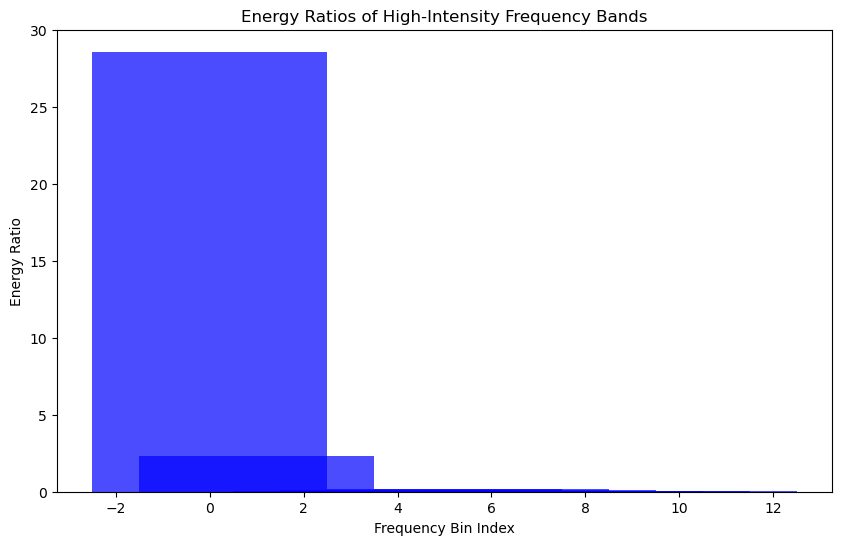

In [1]:
import numpy as np
import scipy.signal as signal
import scipy.io.wavfile as wav
import librosa
import librosa.display
import matplotlib.pyplot as plt

def compute_energy_ratio(audio_file, threshold_factor=1.5, neighbor_bandwidth=10):
    # Load audio file
    sr, audio = wav.read(audio_file)
    if audio.ndim > 1:
        audio = audio.mean(axis=1)  # Convert to mono if stereo
    
    # Compute STFT
    D = np.abs(librosa.stft(audio, n_fft=2048, hop_length=512))
    power_spectrum = np.mean(D**2, axis=1)  # Compute average power per frequency bin
    
    # Identify high-intensity frequencies
    avg_energy = np.mean(power_spectrum)
    high_intensity_indices = np.where(power_spectrum > threshold_factor * avg_energy)[0]
    
    energy_ratios = {}
    for idx in high_intensity_indices:
        band_energy = power_spectrum[idx]
        neighbor_indices = np.arange(max(0, idx - neighbor_bandwidth), min(len(power_spectrum), idx + neighbor_bandwidth))
        neighbor_energy = np.mean([power_spectrum[i] for i in neighbor_indices if i != idx])
        
        if neighbor_energy > 0:
            energy_ratios[idx] = band_energy / neighbor_energy
    
    return energy_ratios

def plot_energy_ratios(audio_file):
    ratios = compute_energy_ratio(audio_file)
    
    if not ratios:
        print("No high-intensity frequencies found.")
        return
    
    plt.figure(figsize=(10, 6))
    plt.bar(ratios.keys(), ratios.values(), width=5, color='b', alpha=0.7)
    plt.xlabel('Frequency Bin Index')
    plt.ylabel('Energy Ratio')
    plt.title('Energy Ratios of High-Intensity Frequency Bands')
    plt.show()

# Example usage
plot_energy_ratios('/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/Sound_data/001029.wav')

Bruker DEMON/sprektrogram data. sammenligner med trigger, evt trigger kun om harmoniske er funnet.

For å finne harmoniske:
Finne verdier i spec over threshhold T.
Gruper etter tidspunkt.
sjekke om harmonier finnes (verdier over T-M)

KeyError: 16

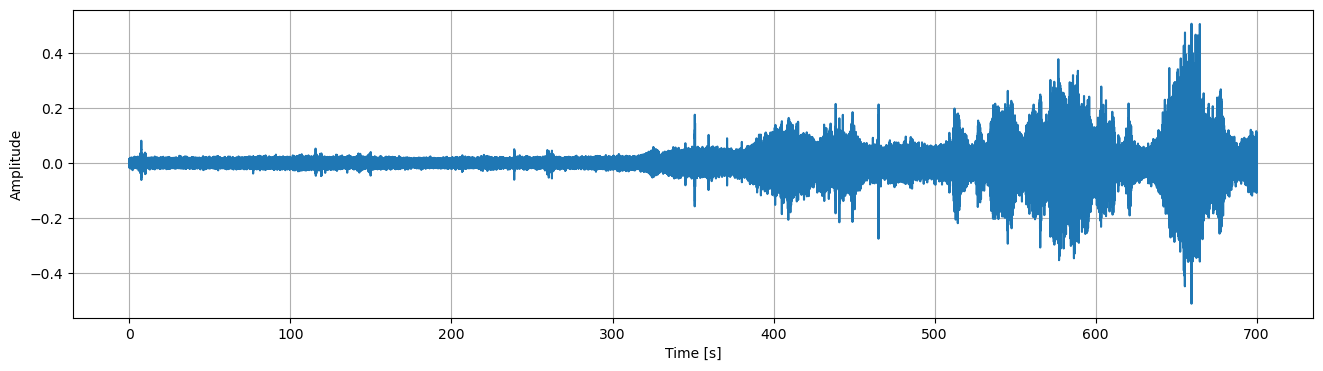

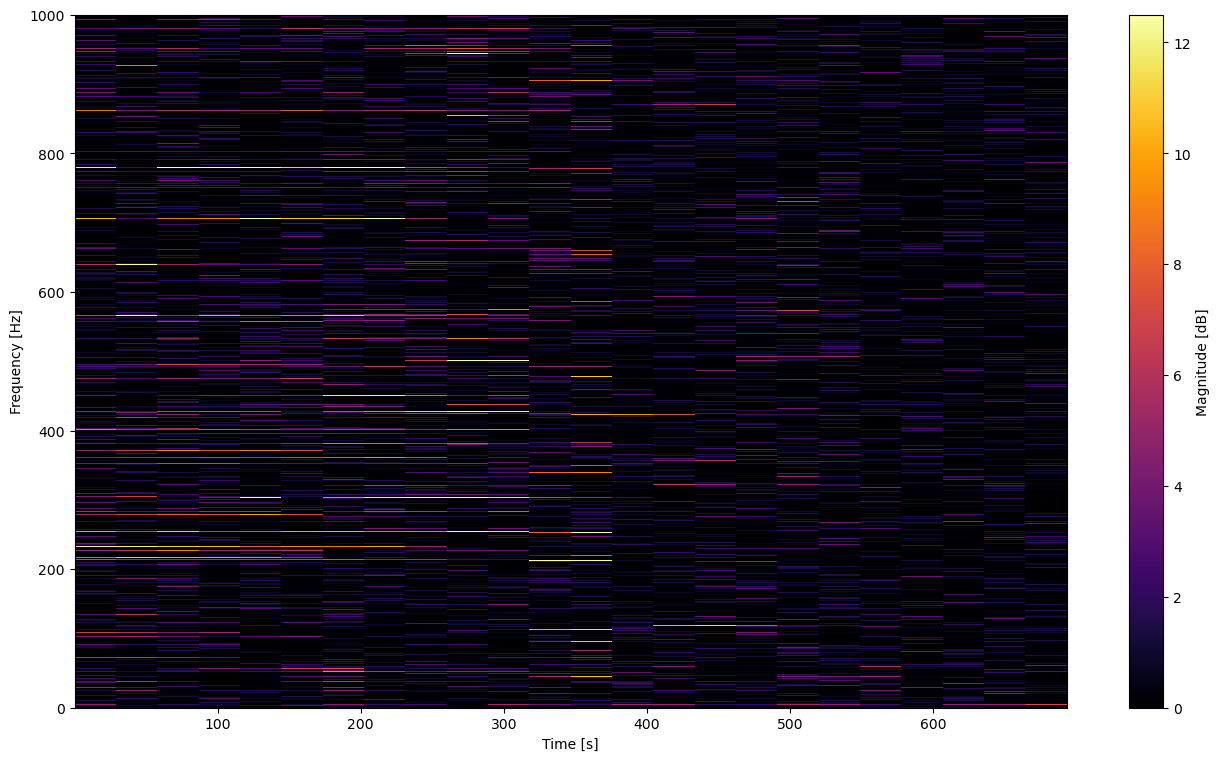

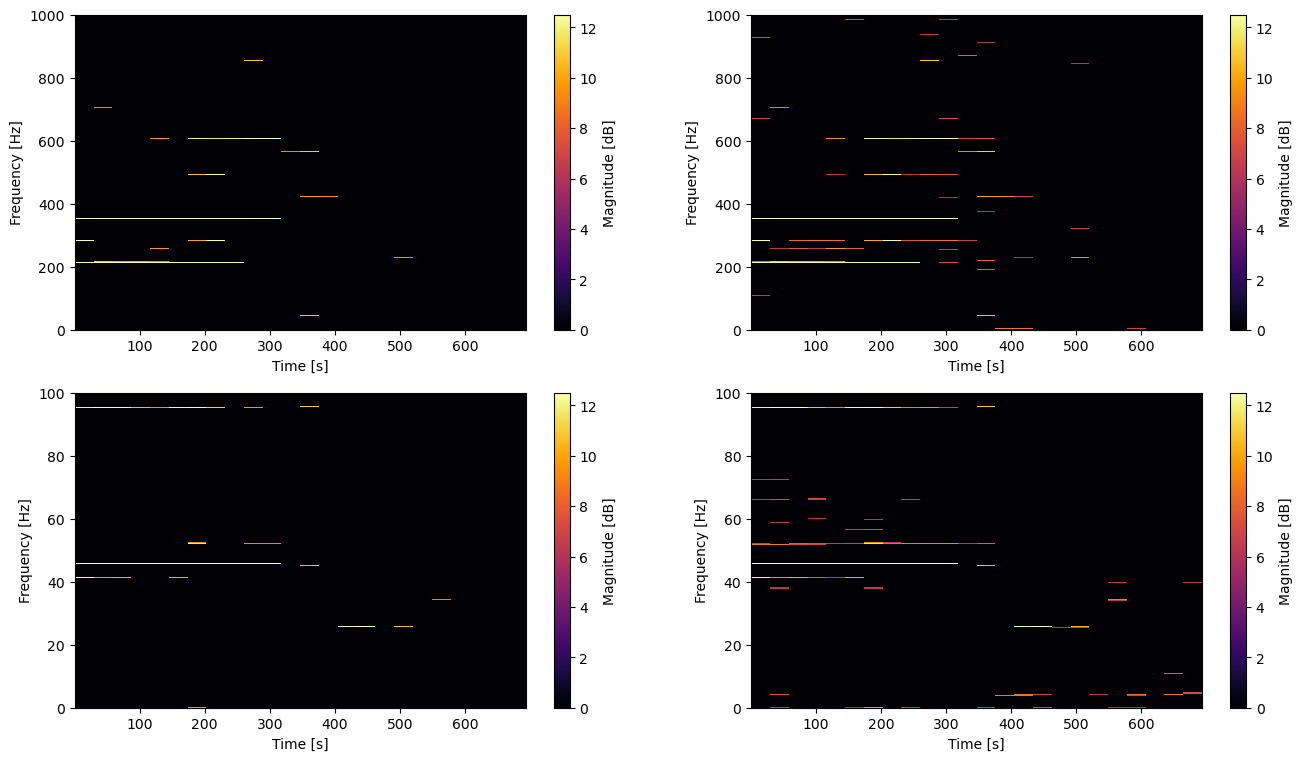

In [ ]:
import functions
from scipy import signal
import librosa
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations

#Broad band and Demon testing
input_file = "/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/Sound_data/2.wav"
output_path = "/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/data/Rapport_figs/Signal_plot.jpeg"
x,fs = functions.load_audiofile(input_file,fs=3000,fc_low=5)
x = x[800*fs:1500*fs]

t = np.linspace(0,len(x)/fs,len(x))
sig = functions.plot_signal(x,t,output_path)


t, f, spec  = functions.plot_spectrogram(x,fs,tperseg=3,freq_filt=13,hfilt_length=30,f_max=1000,s_min=0,s_max=12.5)

T = 9 #Threshhold i dB

over_T = (spec > T)*spec
dB_margin = 3
over_M = (spec > T-dB_margin)*spec
# Plot spectrogram
plt.figure(figsize=(16, 9))  # Define figure for results	
plt.subplot(2, 2, 1)
plt.pcolormesh(t, f, over_T, vmin=0, vmax=12.5, cmap='inferno')  # Draw spectrogram image
plt.xlabel("Time [s]")         # Axis labels and scales
plt.ylabel("Frequency [Hz]")
plt.ylim(0, 1000)
plt.colorbar(label="Magnitude [dB]")  # Colorbar for intensity scale
	
plt.subplot(2, 2, 2)
plt.pcolormesh(t, f, over_M, vmin=0, vmax=12.5, cmap='inferno')  # Draw spectrogram image
plt.xlabel("Time [s]")         # Axis labels and scales
plt.ylabel("Frequency [Hz]")
plt.ylim(0, 1000)
plt.colorbar(label="Magnitude [dB]")  # Colorbar for intensity scale

plt.subplot(2, 2, 3)
plt.pcolormesh(t, f, over_T, vmin=0, vmax=12.5, cmap='inferno')  # Draw spectrogram image
plt.xlabel("Time [s]")         # Axis labels and scales
plt.ylabel("Frequency [Hz]")
plt.ylim(0, 100)
plt.colorbar(label="Magnitude [dB]")  # Colorbar for intensity scale
	
plt.subplot(2, 2, 4)
plt.pcolormesh(t, f, over_M, vmin=0, vmax=12.5, cmap='inferno')  # Draw spectrogram image
plt.xlabel("Time [s]")         # Axis labels and scales
plt.ylabel("Frequency [Hz]")
plt.ylim(0, 100)
plt.colorbar(label="Magnitude [dB]")  # Colorbar for intensity scale

trigger_index = np.array(np.where(spec > T)).T # Array of coordinated (frequency, time)
trigger_margin_index = np.array(np.where(spec > T-dB_margin)).T # Array of coordinated (frequency, time)

#Checking for harmonies
# Grouping frequency values at the same time (coloumn index)
column_groups = {}
for row, col in trigger_index:
    if col not in column_groups:
        column_groups[col] = []
    column_groups[col].append(row)

# Generate potential fundamental frequencies by computing GCDs
tolerance  = 2
candidates = []
fundamentals = {}
for t in range(len(column_groups)):
    for a, b in combinations(column_groups[t], 2):
        gcd_val = np.gcd(a, b)
        if gcd_val > 1 and gcd_val in column_groups[t]:  # Ensure the fundamental exists in the set
            candidates.append(gcd_val)

    # Count occurrences of potential fundamentals
    candidate_counts = Counter(candidates)

    # Filter out weak candidates based on tolerance
    most_common = candidate_counts.most_common()
    if not most_common:
        fundamentals1 = []

    # Cluster candidates around common values
    clustered_fundamentals = []
    for base, _ in most_common:
        if base in column_groups[t] and not any(abs(base - f) < base * tolerance for f in clustered_fundamentals):
            clustered_fundamentals.append(base)
    fundamentals[t]=[]
    fundamentals[t].append(sorted(clustered_fundamentals)) #ønsker et array hvor hver kolonne er en tid



In [3]:
import numpy as np
from collections import Counter
from itertools import combinations

freq_bins = [7,14,21,28,30,60,90,110,112]  # Example bin indices
tolerance=0.05
"""
Identifies possible fundamental frequencies from a list of frequency bin indices.

Parameters:
freq_bins (list): List of detected frequency bin indices.
tolerance (float): Allowed deviation when checking for harmonics.

Returns:
list: Estimated fundamental frequencies.
"""
freq_bins = sorted(freq_bins)
candidates = []

# Generate potential fundamental frequencies by computing GCDs
for a, b in combinations(freq_bins, 2):
    gcd_val = np.gcd(a, b)
    if gcd_val > 1:  # Avoid trivial cases where GCD is 1
        candidates.append(gcd_val)

# Count occurrences of potential fundamentals
candidate_counts = Counter(candidates)

# Filter out weak candidates based on tolerance
most_common = candidate_counts.most_common()
if not most_common:
    fundamentals = []

# Cluster candidates around common values
clustered_fundamentals = []
for base, _ in most_common:
    if not any(abs(base - f) < base * tolerance for f in clustered_fundamentals):
        clustered_fundamentals.append(base)

fundamentals = sorted(clustered_fundamentals)


print("Estimated fundamental frequencies:", fundamentals)


Estimated fundamental frequencies: [2, 3, 4, 7, 10, 14, 28, 30]
